## Analysis of a Buck-Boost Converter

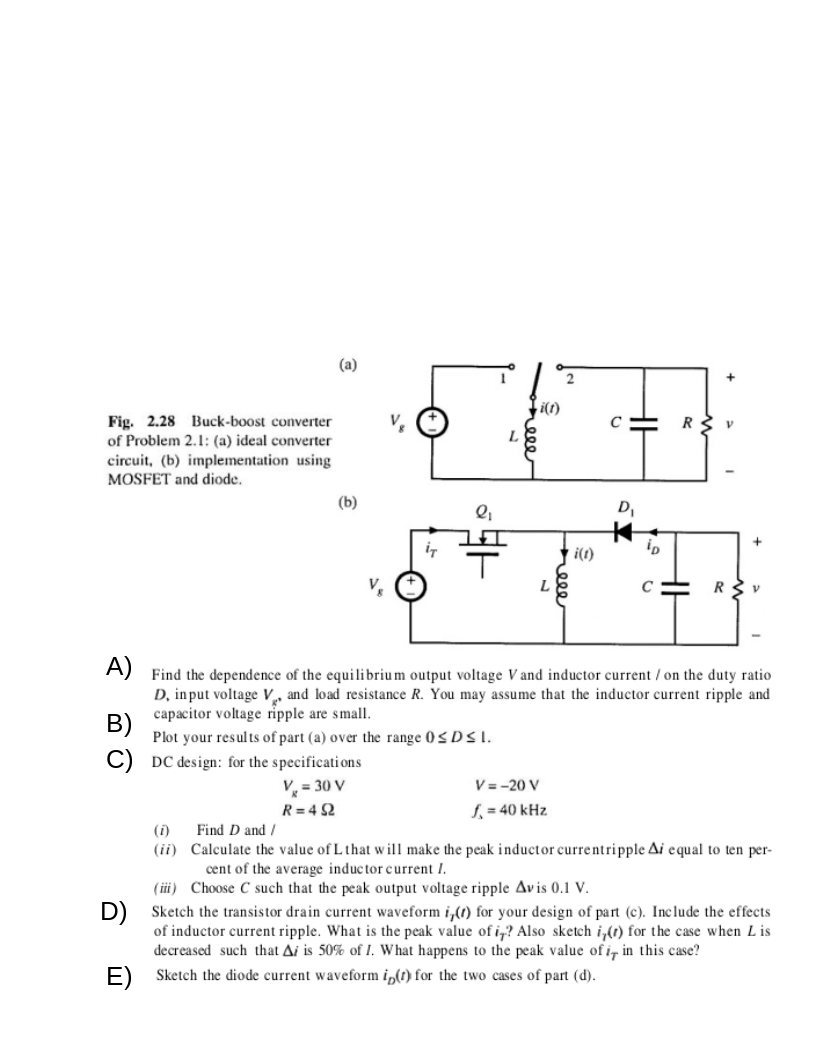

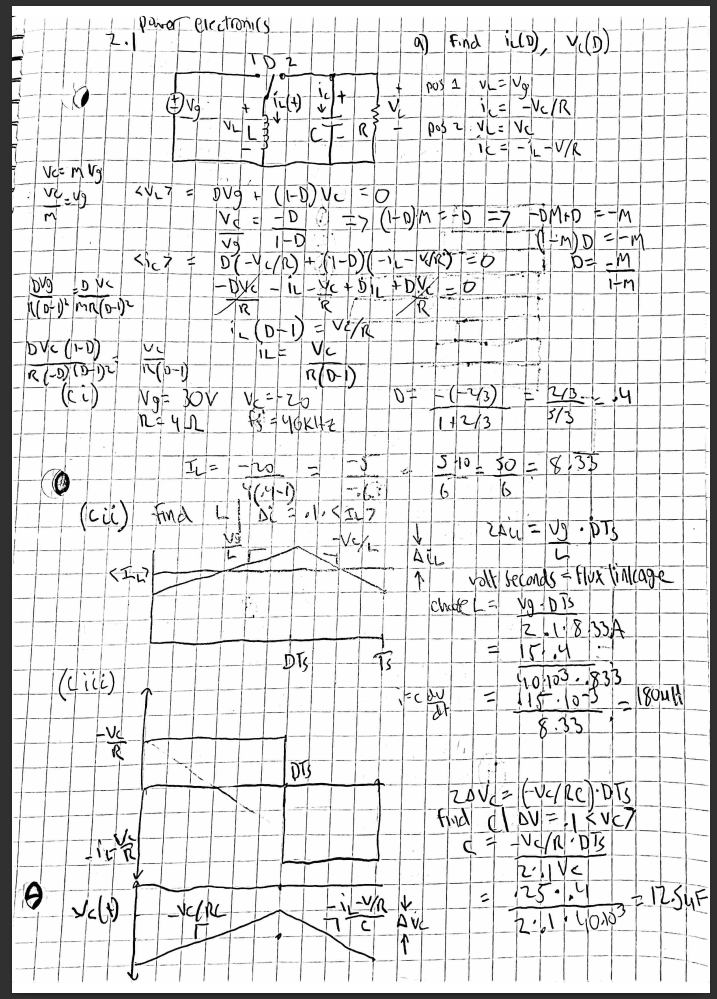

### Import what is needed

In [14]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, Latex
from functools import wraps
import sympy
from sympy.core.symbol import symbols, Symbol
from sympy.solvers.solveset import nonlinsolve
from sympy import solveset
#from sympy import S
from sympy import Eq
from sympy.utilities.lambdify import lambdify
from sympy.printing import latex, pprint
from sympy import Symbol, simplify
#from sympy import srepr
import numpy as np
import os
import matplotlib.pyplot as plt
from math import log10
from PyLTSpice import LTSpice_RawRead
from sympy.solvers import solve

In [15]:
def myprint(*args):
    '''  
    the first argument is the only "lhs"
    subsequent arguments are rhs-s
    '''
    
    def helper(args):
        if len(args) == 0:
            return ''
        else: 
            return f'= {latex(args[0])}' + helper(args[1:])
        
    s = f'$${latex(args[0])} {helper(args[1:])}$$' 
    
    display(Latex(s))   
def myprint2(eq):
    #if isinstance(eq2.func, sympy.core.add.Add):
    if eq.func == sympy.core.add.Add:
        lhs = eq.args[0]
        rhs = -1*eq.args[1]
        myprint(lhs, rhs)
    else:
        print('didnt work')
    return

### Some helper functions

In [16]:
a =3
tab = '\t'
print(f'{tab*a}hi {a} tabs indented')
#print(f'{\'\t\'}hi {a} tabs indented')

			hi 3 tabs indented


In [17]:
def add_method(cls):
    def decorator(func):
        @wraps(func) 
        def wrapper(self, *args, **kwargs): 
            return func(*args, **kwargs)
        setattr(cls, func.__name__, wrapper)
        # Note we are not binding func, but wrapper which accepts self but does exactly the same as func
        return func # returning func means func can still be used normally
    return decorator

class variable(Symbol):
    
    def __init__(self):
        return 

class NotUniqueError(Exception):
    pass


class BuckBoost:
 
    def __init__(self):
        self.equations = set() #expressions assumed to = 0 (Sympy convention)
        self.relations = {} # useful symbolic expressions that are solved for
        self.variables = set()
    def showequations(self):
        for eq in self.equations:
            myprint2(eq)

    #make_symbols()
    def solver(self, given, want, recursesym=None):
        '''
        Parameters
        ----------
        eqs: a list of symbolic equations
        given: a dictionary of symbol:numeric value pairs, if any
        want: the symbol to solve for, if possible

        Returns
        --------
        the given values are substituted into the equations, and then Sympy's nonlinsolve
        is called. 
        '''
        #print('\n top of call:')
        #print(recursesym)
        #print(f'want: {want}')
        tab = '\t'
        
        try:
            if want in recursesym:
                
                print(f'{tab*len(recursesym)}base case')
                return set()
            
        except TypeError:
            recursesym = []
        indents = tab*len(recursesym)
        recursesym.append(want)
        print(f'{indents}{recursesym}')

        rhss = set()
        eqs = self.equations.copy()
        #try all equations together first
        rhs_tuple = nonlinsolve([eq.subs(given) for eq in eqs], want,).args[0]
        # ^ solveset will always return a FiniteSet of solutions for the single variable it can solve for.
        #nonlinsolve will always return a FiniteSet with a single ordered tuple, see documentation ^
        #print(rhs_tuple)
        if len(rhs_tuple) != 1:
            #print(ans)
            raise NotUniqueError
        rhs = rhs_tuple[0]

        rhss.add(rhs)
        #nonlinsolve only returns the first solution it finds. There may be other useful ones too. 


        for eq in eqs:
            #go through each equation individually with solveset

            temp = solveset(eq.subs(given), want) 
            if isinstance(temp, sympy.sets.sets.Complement):
                temp = temp.args[0]
            #print(temp)
            if len(temp) ==0: #happens when symbol being solved for isn't in this equation
                continue #meant to get to next pass in for loop
            else: 
                rhss.add(simplify(temp.args[0]))
                #rhss.add(temp.args[0])

        '''
        substitute a solution for a into c = a/b
        and/or a solution for b in c= a /b

        '''
        #this function returns a set of solutions for a symbol
        #call it again 
        print(f'{indents}so far {want} = {rhss}')
        newrhss = set()
        for sol in rhss:
            print(f'{indents}solution to {want} is: {sol} ')
            for sym in sol.atoms(Symbol):
                
                print(f'{indents}calling solver looking for {sym}')
                for newsub in self.solver(given, sym, recursesym=recursesym):
                    
                    new = sol.subs(sym, newsub)
                    newrhss.add(simplify(new))
                    
                    print(f'{indents}sub-ing in {newsub} for {sym}')
                    print(f'{indents}and found {new}')
                    
                    
                    #newrhss.add(new)


        for eq in newrhss.copy():
            if want in eq.atoms(Symbol):
                newrhss.remove(eq)
        toreturn = rhss.union(newrhss) 
        self.addnewrelation(want, list(toreturn) )
        #print(recursesym)

        return toreturn
    def addnewrelation(self, sym, solutions):
        '''
        The relations dictionary is key= symbol, value=set of expressions that calculate value of symbol
        
        
        
        '''
        funcs = list()
        for exp in solutions: 
            funcs.append(lambdify(list(exp.atoms(Symbol)), exp )) 
            #warnings show when you call a function with a set ^
        self.relations[sym] = funcs
        
        return 
    def computesym(self, sym, given):
        '''
        Parameters
        ----------
        sym: a "lhs" symbol, which is a key to the funcs set of functions
        '''
        for exp in self.relations[sym]:
            try:
                #lambdify_generated functions must have strings for keyword arguments
                temp = dict((key.__str__(), value) for (key, value) in given.items())
                return exp(**temp)
            except KeyError:
                pass
            except TypeError:
                pass

### Define Symbols

In [18]:
def make_symbols():
    global R, C, L, D, s, Vc, Vg, VL, iin, iL, iC, iR, fs, M, delta_iL, delta_vC, Ts
    
    R = symbols('R', real=True, positive=True)
    C = symbols('C', real=True, positive=True)
    L = symbols('L', real=True, positive=True)
    D = symbols('D', real=True, positive=True)
    
    fs = symbols('f_s', real=True, positive=True)
    Ts = 1/fs

    Vc = symbols('V_c', real=True)
    #Vo = symbols('V_o', real=True)
    Vg = symbols('V_g', real= True)
    VL = symbols('V_L', real= True)

    iin = symbols('i_in', real=True)
    iL = symbols('i_L', real=True)
    iC = symbols('i_C', real=True)
    iR = symbols('i_R', real=True)
    delta_iL = symbols('\\Delta\ iL', real=True)
    delta_vC = symbols('\\Delta\ vC', real=True)
    M = symbols('M', real=True)
    #M = Vc/Vg
    return
make_symbols()


### Part (a) - finding average inductor current and capacitor voltage as function of D, Vg, R

In [19]:
converter = BuckBoost()
converter.equations.add(D*Vg + (1-D)*Vc - 0) #VLavg must equal 0 in steady state
converter.equations.add(M - Vc/Vg)
converter.showequations()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [20]:
converter.solver(given={}, want=M)

[M]
so far M = {V_c/V_g}
solution to M is: V_c/V_g 
calling solver looking for V_g
	[M, V_g]
	so far V_g = {V_c/M, V_c - V_c/D}
	solution to V_g is: V_c/M 
	calling solver looking for M
		base case
	calling solver looking for V_c
		[M, V_g, V_c]
		so far V_c = {D*V_g/(D - 1), M*V_g}
		solution to V_c is: D*V_g/(D - 1) 
		calling solver looking for V_g
			base case
		calling solver looking for D
			[M, V_g, V_c, D]
			so far D = {V_c/(V_c - V_g)}
			solution to D is: V_c/(V_c - V_g) 
			calling solver looking for V_g
				base case
			calling solver looking for V_c
				base case
		sub-ing in V_c/(V_c - V_g) for D
		and found V_c*V_g/((V_c - V_g)*(V_c/(V_c - V_g) - 1))
		solution to V_c is: M*V_g 
		calling solver looking for M
				base case
		calling solver looking for V_g
				base case
	sub-ing in D*V_g/(D - 1) for V_c
	and found D*V_g/(M*(D - 1))
	sub-ing in M*V_g for V_c
	and found V_g
	solution to V_g is: V_c - V_c/D 
	calling solver looking for V_c
				base case
	calling solver look

{D/(D - 1), V_c/V_g}

In [27]:
myprint(Vc, *converter.solver(given={}, want=Vc))
#myprint(M, *converter.solver(given={}, want=M))

[V_c]
so far V_c = {D*V_g/(D - 1), R*i_R, M*V_g, R*i_L*(D - 1)}
solution to V_c is: D*V_g/(D - 1) 
calling solver looking for V_g
	[V_c, V_g]
	so far V_g = {V_c/M, V_c - V_c/D}
	solution to V_g is: V_c/M 
	calling solver looking for M
		[V_c, V_g, M]
		so far M = {V_c/V_g}
		solution to M is: V_c/V_g 
		calling solver looking for V_g
			base case
		calling solver looking for V_c
			base case
	sub-ing in V_c/V_g for M
	and found V_g
	calling solver looking for V_c
			base case
	solution to V_g is: V_c - V_c/D 
	calling solver looking for V_c
			base case
	calling solver looking for D
			[V_c, V_g, M, D]
			so far D = {V_c/(V_c - V_g), 1 + V_c/(R*i_L)}
			solution to D is: V_c/(V_c - V_g) 
			calling solver looking for V_g
				base case
			calling solver looking for V_c
				base case
			solution to D is: 1 + V_c/(R*i_L) 
			calling solver looking for R
				[V_c, V_g, M, D, R]
				so far R = {V_c/i_R, V_c/(i_L*(D - 1))}
				solution to R is: V_c/i_R 
				calling solver looking for V_c
			

<IPython.core.display.Latex object>

In [22]:
converter.relations

{D: [<function _lambdifygenerated(V_g, V_c)>],
 V_c: [<function _lambdifygenerated(V_g, D)>,
  <function _lambdifygenerated(M, V_g)>],
 V_g: [<function _lambdifygenerated(M, V_c)>,
  <function _lambdifygenerated(V_c, D)>],
 M: [<function _lambdifygenerated(D)>,
  <function _lambdifygenerated(V_g, V_c)>]}

In [23]:
converter.relations[M]

[<function _lambdifygenerated(D)>, <function _lambdifygenerated(V_g, V_c)>]

In [24]:
print(f' Vc computation test1: {converter.computesym(Vc, {M:-2, Vg:5})}')
print(f' Vc computation test2: {converter.computesym(Vc, {Vg:10, M:3})}')
print(f' Vc computation test3: {converter.computesym(Vc, {Vg:10, D:.3})}')
print(f' M computation test1: {converter.computesym(M, {Vc:-10, Vg:5})}')
print(f' M computation test2: {converter.computesym(M, {D:.4})}')

 Vc computation test1: -10
 Vc computation test2: 30
 Vc computation test3: -4.285714285714286
 M computation test1: -2.0
 M computation test2: -0.6666666666666667


#### Our next equation from hand analysis is capacitor charge balance = 0. From it, we can find average inductor current.

In [25]:
eq2 = D*(-Vc/R)+(1-D)*(-iL-Vc/R) - 0 #iCavg must equal 0 in steady state
converter.equations.add(eq2)
eq3 = R - Vc/iR
converter.equations.add(eq3)
converter.showequations()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [26]:
ans =converter.solver(given={}, want=iL)
myprint(iL, *ans)

[i_L]
so far i_L = {V_c/(R*(D - 1))}
solution to i_L is: V_c/(R*(D - 1)) 
calling solver looking for R
	[i_L, R]
	so far R = {V_c/i_R, V_c/(i_L*(D - 1))}
	solution to R is: V_c/i_R 
	calling solver looking for V_c
		[i_L, R, V_c]
		so far V_c = {D*V_g/(D - 1), R*i_R, M*V_g, R*i_L*(D - 1)}
		solution to V_c is: D*V_g/(D - 1) 
		calling solver looking for V_g
			[i_L, R, V_c, V_g]
			so far V_g = {V_c/M, V_c - V_c/D}
			solution to V_g is: V_c/M 
			calling solver looking for M
				[i_L, R, V_c, V_g, M]
				so far M = {V_c/V_g}
				solution to M is: V_c/V_g 
				calling solver looking for V_g
					base case
				calling solver looking for V_c
					base case
			sub-ing in V_c/V_g for M
			and found V_g
			calling solver looking for V_c
					base case
			solution to V_g is: V_c - V_c/D 
			calling solver looking for V_c
					base case
			calling solver looking for D
					[i_L, R, V_c, V_g, M, D]
					so far D = {V_c/(V_c - V_g), 1 + V_c/(R*i_L)}
					solution to D is: V_c/(V_c - V_g) 
					

<IPython.core.display.Latex object>

In [ ]:
ans =converter.solver(given={}, want=R)
myprint(R, *ans)

In [ ]:
print(f' iL computation test1: {converter.computesym(iL, {R:2, Vc:5, D:.9})}')
print(f' iL computation test2: {converter.computesym(iL, {Vg:10, Vc:-3, R:50})}')

In [ ]:
converter.relations

In [ ]:
iL_func1 = lambdify([Vc, R, D], iL_)
iL_func2 = lambda Vg, R, D: D*Vg/(R*(D-1)**2)
iL_func3 = lambda iR, D: iR/(D-1)
@add_method(BuckBoost)
def iLavg(**kwargs):
    try:
        return iL_func1(kwargs['Vc'], kwargs['R'], kwargs['D'])
    except KeyError:
        try: 
            return iL_func2(kwargs['Vg'], kwargs['R'], kwargs['D'])
        except KeyError:
            return iL_func3(kwargs['iR'], kwargs['D'])
    

In [ ]:
print(f'Example call to iLavg(Vc={10},R={5},D={.8}) = {converter.iLavg(Vc=10, R=5, D=.8):.3f}')
print(f'Example call to iLavg(Vg={20},R={2},D={.1}) = {converter.iLavg(Vg=20, R=2, D=.1):.3f}')
print(f'Example call to iLavg(iR={20},D={.1}) = {converter.iLavg(iR=20, D=.1):.3f}')

In [ ]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "last"

### Part (B) - plotting
- plot output voltage (same as capacitor voltage) as function of D
- plot average inductor current as function of D, for a few different loads.
- Note that iR = Vc/R

In [ ]:
D= np.linspace(0, .99, 100)
fig, ax = plt.subplots(subplot_kw={'title':' (ideal) M(D) of Buck-Boost'})
M = converter.M(D=D)
ax.plot(D, M)
ax.set_xlabel('Duty Cycle')
ax.set_ylabel('Conversion Ratio')
#plot again, but zoom in 
fig, ax = plt.subplots(subplot_kw={'title':'(ideal) M(D) of Buck-Boost'})
ax.plot(D, M)
ax.set_xlabel('Duty Cycle')
ax.set_ylabel('Conversion Ratio')
ax.set_ylim(bottom=-1, top=0)
ax.set_xlim(left=0, right=.6)
ax.grid()

load_currents = [.1, .2, .5, 1, 5]
fig, ax = plt.subplots(subplot_kw={'title':'Inductor Current of Buck Boost'})
for i in load_currents:    
    #il = i/(D-1)
    il = converter.iLavg(iR = i, D=D)
    ax.plot(D, il, label='load: {:.1f}A'.format(i))
ax.legend()
ax.set_xlabel('Duty Cycle')
ax.set_xlim(left=.3, right=.5)
ax.set_ylim(bottom=-10, top=0)
ax.set_ylabel('inductor current [A]')


### Part C.i) find D and iL for the given values

In [ ]:
#Vg = 30
#R = 4
#Vc = -20 
#fs = 40e3
'''
Answer: Just use those nice plots! 
M = Vc/Vg = -20/30 = -.66
Duty cycle looks to be about .38, from the plot
Then iL = Vc/(R*(D-1)) = -8A
Alternatively, use a solver from Sympy, see below. 
'''


In [ ]:
#from IPython.display import display, Latex
#from sympy.solvers.solveset import nonlinsolve

In [ ]:
make_symbols()

In [ ]:
given = {Vg:30, R:4, Vc:-20, fs:40e3, M:-20/30}

In [ ]:
print(converter.equations )    
print(converter.relations)

In [ ]:
converter.solver(given=given, want=[D,iL])

In [ ]:
#make_symbols()
converter.relations

In [ ]:
type(converter.relations[iL])
converter.relations[iL]

### Part C.ii) What value of inductance will make the ripple current = 10% of average current?

In [ ]:
converter.equations.add(M - Vc/Vg ) #conversion ratio M
converter.equations.add(2*delta_iL - Vg*D*Ts/L) #inductor current ripple
converter.equations.add(2*delta_vC - (Vc/R)*(1/C)*D*Ts) #capacitor voltage ripple
converter.equations.add(delta_iL - .1*iL) #design spec
converter.equations.add(delta_vC - .1*Vc) #design spec
converter.equations.add(iL - Vc/(R*(D-1))) #average inductor current

In [ ]:
given = {Vg:30, R:4, Vc:-20, fs:40e3, M:-20/30, D:.4, delta_iL:8.333/10}

In [ ]:
converter.relations

In [ ]:
converter.solver( given=given, want=[L])

### Part C.iii) What value of capacitance will make the ripple voltage = 10% of average voltage?

In [ ]:
given = {Vg:30, R:4, Vc:-20, fs:40e3, M:-20/30, D:.4, delta_vC: -20/10}

In [ ]:
converter.solver( given=given, want=[C])

### Part D) Plot the transistor drain current for a switching period, dependent on L

The transistor drain current is the inductor current while its on, and zero when its not. It can be represented with 5 points: (avg - rip, 0), (avg, DTs/2), (avg + rip, DTs), (0, D*Ts+(1-D)*Ts/2), (avg - rip, Ts).

The expressions for the ripple amounts were included in the equations of parts (Cii) and (Ciii), and are from 
the hand analysis. The inputs are are: Vg, D, R, L, C, Ts. 


In [ ]:
#path_to_raw = 'C:\\Users\\Erik.Iverson\\Documents\\LTspiceXVII\\idc_stage1\\'
raw = os.path.join(os.getcwd(), 'problem2-1.raw')
LTR = LTSpice_RawRead.LTSpiceRawRead(raw) 
Vc = LTR.get_trace("V(vc)").get_wave()
iT = LTR.get_trace("I(S1)").get_wave()
iL = LTR.get_trace("I(L1)").get_wave()
t_sim = LTR.get_trace('time').get_time_axis()

In [ ]:
#delta_iL = solveset(eq4, delta_iL).args[0]
#myprint(symbols('\\Delta\ i_L'), delta_iL)
#delta_vC = solveset(eq5, delta_vC).args[0]
#myprint(symbols('\\Delta\ v_C'), delta_vC)

converter.solver(given={}, want=[delta_iL])

In [ ]:
delta_iL = lambdify([D, fs, Vg, R, L, C], delta_iL)
delta_vC = lambdify([D, fs, Vg, R, L, C], delta_vC)

In [ ]:
converter.relations

In [ ]:
iL.doit()